Initialize Google Earth Engine (GEE)

In [15]:
import ee
import geemap
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

ee.Authenticate()
ee.Initialize()

Define Fire Metadata

In [16]:
fires = {
    "dixie_fire": {
        # Dixie Fire AOI (approx perimeter)
        "aoi": ee.Geometry.Polygon(
            [[[-121.6, 39.9], [-120.6, 39.9], [-120.6, 40.5], [-121.6, 40.5], [-121.6, 39.9]]]
        ),
        "start": "2021-07-01",
        "end": "2021-10-01"
    },
    "camp_fire": {
        # Camp Fire AOI (Butte County, CA)
        "aoi": ee.Geometry.Polygon(
            [[[-121.75, 39.6], [-121.3, 39.6], [-121.3, 40.1], [-121.75, 40.1], [-121.75, 39.6]]]
        ),
        "start": "2018-11-01",
        "end": "2018-12-15"
    },
    "bootleg_fire": {
        # Bootleg Fire AOI (Lake County, OR)
        "aoi": ee.Geometry.Polygon(
            [[[-121.2, 42.3], [-120.2, 42.3], [-120.2, 42.8], [-121.2, 42.8], [-121.2, 42.3]]]
        ),
        "start": "2021-07-01",
        "end": "2021-08-31"
    },
    "caldor_fire": {
        # Caldor Fire AOI (Eldorado County, CA)
        "aoi": ee.Geometry.Polygon(
            [[[-120.8, 38.6], [-120.2, 38.6], [-120.2, 39.1], [-120.8, 39.1], [-120.8, 38.6]]]
        ),
        "start": "2021-08-01",
        "end": "2021-10-01"
    },
    "east_troublesome_fire": {
        # East Troublesome Fire AOI (Grand County, CO)
        "aoi": ee.Geometry.Polygon(
            [[[-106.2, 40.0], [-105.6, 40.0], [-105.6, 40.4], [-106.2, 40.4], [-106.2, 40.0]]]
        ),
        "start": "2020-10-01",
        "end": "2020-11-15"
    }
}

Visualize single-band Rasters

In [17]:
def quick_plot(path, cmap="viridis", vmin=None, vmax=None):
    with rasterio.open(path) as src:
        data = src.read(1)
    plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(path.split("/")[-1])
    plt.show()

Output Folder

In [18]:
output_folder = "../data/raw"
os.makedirs(output_folder, exist_ok=True)

Load and Explore Each Event

In [19]:
for fire_name, fire_info in fires.items():
    print(f"Processing {fire_name}...")
    aoi = fire_info["aoi"]
    start, end = fire_info["start"], fire_info["end"]

    # ---- Datasets ----

    # MODIS Burned Area (label)
    modis = (
        ee.ImageCollection("MODIS/061/MCD64A1")
        .filterDate(start, end)
        .filterBounds(aoi)
        .select("BurnDate")
        .max()
    )

    # Sentinel-2 NDVI (downsample to 30 m)
    ndvi = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterDate(start, end)
        .filterBounds(aoi)
        .map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('NDVI'))
        .mean()
        .resample("bilinear")
        .reproject("EPSG:4326", None, 30)
    )

    # ESA WorldCover Landcover
    landcover = ee.Image("ESA/WorldCover/v200/2021").clip(aoi)

    # ERA5-Land Temperature (downsample to ~1km)
    era5 = (
        ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
        .filterDate(start, end)
        .filterBounds(aoi)
        .select("temperature_2m")
        .mean()
        .resample("bilinear")
        .reproject("EPSG:4326", None, 1000)
    )

    # CHIRPS Precipitation (downsample to ~5km)
    chirps = (
        ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
        .filterDate(start, end)
        .filterBounds(aoi)
        .select("precipitation")
        .sum()
        .resample("bilinear")
        .reproject("EPSG:4326", None, 5000)
    )

    # SRTM DEM
    srtm = ee.Image("USGS/SRTMGL1_003").clip(aoi)

    # ---- Export Dictionary ----
    datasets = {
        "modis_burned_area": modis,
        "ndvi": ndvi,
        "esa_landcover": landcover,
        "era5_mean_temp": era5,
        "chirps_precip": chirps,
        "srtm_dem": srtm
    }

    for ds_name, image in datasets.items():
        out_path = os.path.join(output_folder, f"{fire_name}_{ds_name}.tif")
        print(f"  Exporting {fire_name} - {ds_name}...")
        try:
            geemap.ee_export_image(
                image,
                filename=out_path,
                scale=30 if ds_name not in ["modis_burned_area", "era5_mean_temp", "chirps_precip"] else None,
                region=aoi,
                file_per_band=False
            )
        except Exception as e:
            print(f"  Error exporting {ds_name}: {e}")

Processing dixie_fire...
  Exporting dixie_fire - modis_burned_area...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\johnm\Desktop\Comp-Sci-App-State\Capstone\Wildfire-Lifecycle\data\raw\dixie_fire_modis_burned_area.tif
  Exporting dixie_fire - ndvi...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\johnm\Desktop\Comp-Sci-App-State\Capstone\Wildfire-Lifecycle\data\raw\dixie_fire_ndvi.tif
  Exporting dixie_fire - esa_landcover...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\johnm\Desktop\Comp-Sci-App-State\Capstone\Wildfire-Lifecycle\data\raw\dixie_fire_esa_landcover.tif
  Exporting dixie_fire - era5_mean_temp...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\johnm\Desktop\Comp-Sci-App-State\Capstone\Wildfire-Lifecycle\data\raw\dixie_fire_era5_mean_temp.tif
  Exporting dixie_fire - chirps_precip...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\johnm\Desktop\Comp-Sci-App-State\Capstone\Wildfire-Lifecycle\d

Quick Visualization Check

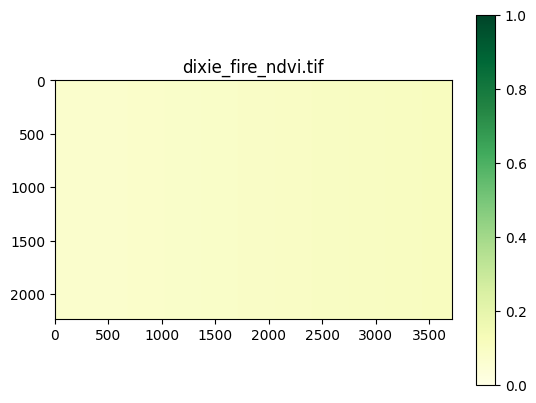

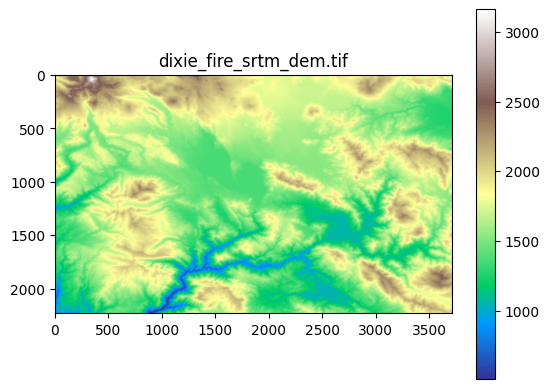

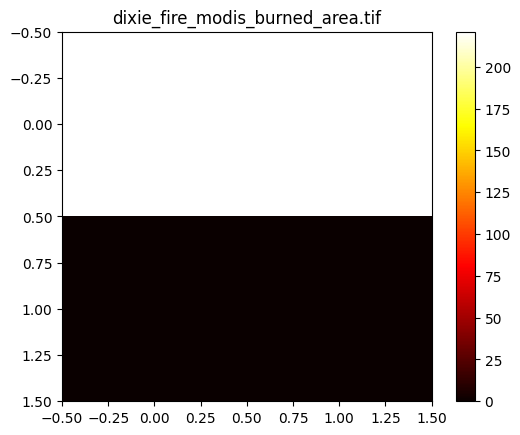

In [21]:
quick_plot("../data/raw/dixie_fire_ndvi.tif", cmap="YlGn", vmin=0, vmax=1)
quick_plot("../data/raw/dixie_fire_srtm_dem.tif", cmap="terrain")
quick_plot("../data/raw/dixie_fire_modis_burned_area.tif", cmap="hot")